In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import os, os.path 
import numpy as np
import pickle
from glob import glob
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
"""Change to the data folder"""
train_path = "new_train/new_train"
pred_path="new_val_in/new_val_in"
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None,p=1.0,test=False):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        self.test=test
        self.p=p
    def __len__(self):
        return int(len(self.pkl_list)*self.p)

    def __getitem__(self, idx):
        if(self.test):
            idx+=int(len(self.pkl_list)*self.p)
        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=train_path,p=0.15)
test_dataset  = ArgoverseDataset(data_path=train_path,p=0.15,test=True)
pred_dataset  = ArgoverseDataset(data_path=pred_path)

### Create a loader to enable batch processing

In [3]:
batch_sz = 256

#inp_shape [batch_sz,60,19,4]
#out_shape [batch_sz,60,30,4]
def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
#     for scene in batch:
#         print(scene['p_in'][numpy.where(scene['track_id'][:,0,:]==scene['agent_id'])[0]].shape)
#         print(scene['p_in'][numpy.where(scene['track_id'][:,0,:]==scene['agent_id'])[0]])
#         print(numpy.where(scene['track_id']==scene['agent_id'])[0])
#         print(scene['lane_norm'].shape)
#         print(scene['lane_norm'])
#         print('lane')
#         print(scene['lane'].shape)
#         print(scene['lane'])  
    inp = [np.dstack([scene['p_in'][np.where(scene['track_id'][:,0,:]==scene['agent_id'])[0]], 
                         scene['v_in'][np.where(scene['track_id'][:,0,:]==scene['agent_id'])[0]]]) for scene in batch]
    out = [np.dstack([scene['p_out'][np.where(scene['track_id'][:,0,:]==scene['agent_id'])[0]],
                         scene['v_out'][np.where(scene['track_id'][:,0,:]==scene['agent_id'])[0]]]) for scene in batch]
    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    inp = torch.squeeze(inp, 1)
    out = torch.squeeze(out, 1)

    return [inp, out]

#inp_shape [batch_sz,60,19,4]
#scene_idx
#indecx of each agent in each sence
def test_collate(batch):
    inp = [np.dstack([scene['p_in'][np.where(scene['track_id'][:,0,:]==scene['agent_id'])[0]], 
                         scene['v_in'][np.where(scene['track_id'][:,0,:]==scene['agent_id'])[0]]]) for scene in batch]
    inp = torch.FloatTensor(inp)
    inp = torch.squeeze(inp, 1)
    scene_id=[scene['scene_idx'] for scene in batch]
    scene_id=torch.IntTensor(scene_id)
    # index of the agent vehich 
#     agent_id_index=[] 
#      # id of the agent vehich
#     scene_id=[]  
#     for scene in batch:
#         actual_objects=scene['track_id']
#         actual_objects=actual_objects[:,0,:]
#         agent_id_index.append(numpy.where(actual_objects==scene['agent_id'])[0])
#         scene_id.append(scene['scene_idx'])
    
#     agent_id_index=torch.IntTensor(agent_id_index)
    return [inp,scene_id]




val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=1)
test_loader = DataLoader(test_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=1)
pred_loader = DataLoader(pred_dataset,batch_size=batch_sz, shuffle = False, collate_fn=test_collate, num_workers=1)

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size=4, embedding_size=512, hidden_size=1024):
        super(EncoderRNN, self).__init__()
        self.hidden_size=hidden_size
        
        self.embd_dropout = nn.Dropout(0.4)
        self.fc=nn.Linear(input_size,embedding_size)
        
        self.lstm=nn.LSTMCell(embedding_size,hidden_size)
        self.lstm1=nn.LSTMCell(hidden_size,hidden_size)
        
    def forward(self,x:torch.FloatTensor,hidden):
        embedded=F.relu(self.fc(x))
        embedded = self.embd_dropout(embedded)
        hidden = self.lstm(embedded,hidden)

        return hidden

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self,  embedding_size=512, hidden_size=1024, output_size=4):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embd_dropout = nn.Dropout(0.4)
        self.linear1 = nn.Linear(output_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x,hidden):
        embedded = F.relu(self.linear1(x))
        embedded = self.embd_dropout(embedded)
        hidden = self.lstm1(embedded, hidden)
        output = self.linear2(hidden[0])
        return output, hidden


In [6]:
class lstm_seq2seq(nn.Module):
    def __init__(self):
        super(lstm_seq2seq,self).__init__()
        self.Encoder=EncoderRNN().to(device)
        self.Decoder=DecoderRNN().to(device)
    def forward(self,x,forcing=False,out=None):
        input_length = x.shape[1]
        batch_size = x.shape[0]
   
        encoder_hidden= (
            torch.zeros(batch_size, self.Encoder.hidden_size).to(device),
            torch.zeros(batch_size, self.Encoder.hidden_size).to(device),
        )
        for ei in range(input_length-1):
            encoder_input = x[:, ei, :]-x[:, ei+1, :]
            encoder_hidden = self.Encoder(encoder_input,encoder_hidden)
        
        rollout_len=30
        decoder_input=encoder_input
        
        decoder_hidden = encoder_hidden
        # shape of output batch_size*object timestep feature
        decoder_outputs= torch.zeros((x.size(0),rollout_len,x.size(2))).to(device)    
        decoder_outputs[:,0,:]=x[:,-1,:]
        
        
        for di in range(rollout_len):
            decoder_output, decoder_hidden = self.Decoder(decoder_input,decoder_hidden)
            decoder_input=decoder_output
            # Update loss
            if(di==0):
                decoder_outputs[:, di, :] += decoder_output
                if forcing:
                    decoder_input=out[:,di,:]-x[:,-1,:]
            else:
                decoder_outputs[:, di, :] = decoder_output+decoder_outputs[:, di-1, :]
                if forcing:
                    decoder_input=out[:,di,:]-out[:,di-1,:]
        return  decoder_outputs
#     def predict(self,x):
#         input_length = x.shape[1]
#         batch_size = x.shape[0]
   
#         encoder_hidden= (
#             torch.zeros(batch_size, self.Encoder.hidden_size).to(device),
#             torch.zeros(batch_size, self.Encoder.hidden_size).to(device),
#         )
#         for ei in range(input_length-1):
#             encoder_input = x[:, ei, :]-x[:, ei+1, :]
#             encoder_hidden = self.Encoder(encoder_input,encoder_hidden)
        
#         rollout_len=30
#         decoder_input=encoder_input
        
#         decoder_hidden = encoder_hidden
#         # shape of output batch_size*object timestep feature
#         decoder_outputs= torch.zeros((x.size(0),rollout_len,x.size(2))).to(device)    
#         decoder_outputs[:,0,:]=x[:,-1,:]
        
#         #loss trnsor
#         for di in range(rollout_len):
#             decoder_output, decoder_hidden = self.Decoder(decoder_input,decoder_hidden)
#             decoder_input = decoder_output
#             # Update loss
#             if(di==0):
#                 decoder_outputs[:, di, :] += decoder_output
#             else:
#                 decoder_outputs[:, di, :] = decoder_output+decoder_outputs[:, di-1, :]
#         return  decoder_outputs

### Visualize the batch of sequences

In [7]:
import matplotlib.pyplot as plt
import random



def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out, perd = sample_batch
    batch_sz = inp.size(0)
    
    fig, axs = plt.subplots(1,4, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(4):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        #axs[i].scatter(out[i,:,0], perd[i,:,1])
    plt.show()
    
# seq2seq rnn
def train(val_loader,model,Optimizer,device):
    total_loss=0
    model.train()
    decoder_outputs=0
    count=0
    for i_batch, sample_batch in enumerate(tqdm(val_loader)):
        inp, out = sample_batch
        
        inp,out=inp.to(device),out.to(device)

    
        # reshape batch_size*object timestep feature
        loss = 0
        Optimizer.zero_grad()

        # shape of output batch_size*object timestep feature
        decoder_outputs=model(inp,forcing=False,out=out)
        loss=(torch.mean((decoder_outputs-out)**2))**0.5

        total_loss+=loss.item()
        # Backpropagate
        loss.backward()
        Optimizer.step()
        count+=1

        # sample
        #show_sample_batch((inp.cpu(),out.cpu(),decoder_outputs.cpu().detach().numpy()))
    print("total:{}".format(total_loss/count))    
    return total_loss/count
    """TODO:
      Deep learning model
      training routine
    """
#show_sample_batch(sample_batch, agent_id)
# break

In [8]:
def test(test_loader,model,device):
    model.eval()
    total_loss=0
    count=0
    with torch.no_grad():
        for inp,out in test_loader:
            inp,out=inp.to(device),out.to(device)
            decoder_outputs=model(inp)
            loss=(torch.mean((decoder_outputs-out)**2))**0.5

            total_loss+=loss.item()
            count+=1;
    return total_loss/count 

In [9]:
def predict(pred_loader,model,device):
    model.eval()
    perd_p_out=torch.zeros((1,61)).to(device)
    with torch.no_grad():
        for inp , scene_id in pred_loader:
            inp,scene_id=inp.to(device),scene_id.to(device)

            decoder_outputs=model(inp)
            batch_size=decoder_outputs.size(0)
            # submistion formatting 
            for i in range(batch_size):
                #one agent perdition 
                temp=torch.cat(((scene_id[i].reshape(1,1)).float(),decoder_outputs[i,:,:2].reshape(60,1)),dim=0).to(device)
                temp=temp.reshape(1,61)
                #stack all agent perdtion
                perd_p_out=torch.cat((perd_p_out,temp),dim=0)         
    return perd_p_out 

In [10]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model=lstm_seq2seq().to(device)

In [11]:
from torch.optim.lr_scheduler import StepLR
momentum = 0.9
# batch size is 100 
# error=nn.MSELoss()
# np.exp(-10)
learning_rate=0.001
Optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(Optimizer, step_size=10, gamma=0.1)

In [20]:
num_epoch = 40
train_loss=np.zeros((num_epoch,))
test_loss=np.zeros((num_epoch,))
for epoch in range(0, num_epoch):
    print("epoch",epoch)
    train_loss[epoch]=train(val_loader,model,Optimizer,device)
    test_loss[epoch]=test(test_loader,model,device)
    scheduler.step()


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 0


100%|██████████| 121/121 [00:56<00:00,  2.15it/s]

total:2.810089668951744



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 1


100%|██████████| 121/121 [00:35<00:00,  3.41it/s]

total:2.814052337457326



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 2


100%|██████████| 121/121 [00:22<00:00,  5.38it/s]

total:2.808903447852647



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 3


100%|██████████| 121/121 [00:18<00:00,  6.60it/s]

total:2.8099565466573417



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 4


100%|██████████| 121/121 [00:19<00:00,  6.29it/s]

total:2.8110156453345434



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 5


100%|██████████| 121/121 [00:17<00:00,  7.00it/s]

total:2.810077657384321



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 6


100%|██████████| 121/121 [00:19<00:00,  6.19it/s]

total:2.8144204636250647



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 7


100%|██████████| 121/121 [00:17<00:00,  6.84it/s]

total:2.8110686786903822



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 8


100%|██████████| 121/121 [00:17<00:00,  7.04it/s]

total:2.8099686232480137



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 9


100%|██████████| 121/121 [00:18<00:00,  6.56it/s]

total:2.8101925337610165



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 10


100%|██████████| 121/121 [00:17<00:00,  6.79it/s]

total:2.809621227674248



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 11


100%|██████████| 121/121 [00:17<00:00,  6.77it/s]

total:2.810707486365452



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 12


100%|██████████| 121/121 [00:16<00:00,  7.39it/s]

total:2.810338834100518



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 13


100%|██████████| 121/121 [00:18<00:00,  6.50it/s]

total:2.8063580339605156



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 14


100%|██████████| 121/121 [00:17<00:00,  6.88it/s]

total:2.810735056222963



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 15


100%|██████████| 121/121 [00:16<00:00,  7.24it/s]

total:2.8123882230648323



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 16


100%|██████████| 121/121 [00:20<00:00,  6.00it/s]

total:2.8095692839504274



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 17


100%|██████████| 121/121 [00:18<00:00,  6.70it/s]

total:2.8109742609922552



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 18


100%|██████████| 121/121 [00:18<00:00,  6.59it/s]

total:2.8134547718300307



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 19


100%|██████████| 121/121 [00:18<00:00,  6.50it/s]

total:2.8109259644815743



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 20


100%|██████████| 121/121 [00:18<00:00,  6.63it/s]

total:2.8091372281066644



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 21


100%|██████████| 121/121 [00:18<00:00,  6.55it/s]

total:2.8119349775235514



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 22


100%|██████████| 121/121 [00:19<00:00,  6.22it/s]

total:2.8134722552023645



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 23


100%|██████████| 121/121 [00:18<00:00,  6.55it/s]

total:2.8129976308050235



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 24


100%|██████████| 121/121 [00:19<00:00,  6.31it/s]

total:2.8076520675470023



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 25


100%|██████████| 121/121 [00:18<00:00,  6.61it/s]

total:2.811251644260627



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 26


100%|██████████| 121/121 [00:17<00:00,  6.81it/s]


total:2.810915950901252


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 27


100%|██████████| 121/121 [00:19<00:00,  6.32it/s]

total:2.8114457741256587



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 28


100%|██████████| 121/121 [00:18<00:00,  6.62it/s]

total:2.8097722018060605



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 29


100%|██████████| 121/121 [00:17<00:00,  6.77it/s]

total:2.8088494627928933



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 30


100%|██████████| 121/121 [00:19<00:00,  6.07it/s]

total:2.811896907396553



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 31


100%|██████████| 121/121 [00:17<00:00,  6.84it/s]

total:2.811149853320161



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 32


100%|██████████| 121/121 [00:17<00:00,  6.82it/s]

total:2.8090712038938666



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 33


100%|██████████| 121/121 [00:17<00:00,  6.96it/s]

total:2.810556602872108



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 34


100%|██████████| 121/121 [00:16<00:00,  7.56it/s]

total:2.811868876465096



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 35


100%|██████████| 121/121 [00:18<00:00,  6.47it/s]

total:2.812890590715014



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 36


100%|██████████| 121/121 [00:18<00:00,  6.61it/s]

total:2.8072555084859045



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 37


100%|██████████| 121/121 [00:17<00:00,  6.80it/s]

total:2.809894201184107



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 38


100%|██████████| 121/121 [00:18<00:00,  6.52it/s]

total:2.8125011349512525



  0%|          | 0/121 [00:00<?, ?it/s]

epoch 39


100%|██████████| 121/121 [00:16<00:00,  7.47it/s]

total:2.8076817989349365


In [21]:
print(sum(p.numel() for p in model.parameters()))

21005316


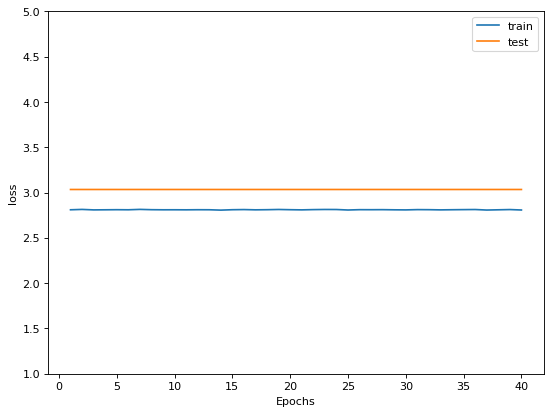

In [22]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
x_ax=np.linspace(1, num_epoch, num_epoch)

plt.plot(x_ax,train_loss,label='train')
plt.plot(x_ax,test_loss,label='test')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.ylim(1,5)
plt.legend()
plt.show()

In [23]:
sample_p=predict(pred_loader,model,device)
#remove the zero
sample_p=sample_p[1:,:]

for inp,scene_id in pred_loader:
    inp,scene_id.to(device)

In [24]:
data=pd.read_csv('sample_submission.csv', index_col=False)
if is_cuda:
    sample_p=sample_p.cpu()
sample_p_df=pd.DataFrame(sample_p.numpy(),columns=data.columns)
sample_p_df['ID']=sample_p_df['ID'].astype(int)

In [25]:
sample_p_df.to_csv('sample_test.csv',index=False)

In [18]:
# ex= torch.zeros((4,)).to(device)
# ex_seq=torch.zeros((4,)).to(device)
# count=0
# for i_batch,sample_batch in enumerate(val_loader):
#     inp,out=sample_batch
#     inp= inp.to(device).float()
#     out= out.to(device).float()
#     mixed=torch.cat((inp,out),1).to(device)
#     mixed=mixed.reshape((-1,4))
#     count=len(mixed)+count
#     ex=(ex+torch.sum(mixed,0))
#     ex_seq=ex_seq+torch.sum(mixed**2,0)
# mean=ex/count
# variance=mean**2-ex_seq/count
# std=(-variance)**0.5

In [19]:
# X= [ .....]
# for x in X :
#     if x is not 0;
#         accept 
#     else 
#         if m accept w 
#             accept 
#         else
#             reject 